# Análise conclusiva de subnotificações de SRAG provocada por Covid-19 no Brasil

## Integrantes do grupo
 - Daniel Fernandes Pinho (EF02634 - Florestal)
 - Mateus Pinto da Silva (EF03489 - Florestal)
 - Milena Nobres (ER05164 - Rio Paranaíba)

**Observacao:** Para a correta execução deste notebook, é necessário ter baixado e processado os dados utilizando os scripts **download_raw_data.py** e **process_data.py**, ou ter baixado os dados já processados através do link https://drive.google.com/file/d/1knTUgLZHLQcBF9CmCdHWk-WP94AXh2_J/view?usp=sharing e colocado o arquivo .parquet descompactado na pasta raiz_repositorio/data/processed.

## Decisões desta etapa
Optamos por seguir a divisão dos 3 conjuntos de dados da última entrega. Assim, os dados que seguramente são covid e que seguramente não são covid formam juntos o conjunto de treino, e os dados possíveis de subnotificação como dados de treino. Então aqui tentaremos ver se é possível identificar subnotificações e se sim, tentar aproximar qual a porcentagem de casos subnotificados.

In [1]:
import missingno as msno
import pandas as pd
import matplotlib as mpl

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import numpy as np

from common.path import *

mpl.rc('figure', figsize=(10, 7))

In [2]:
raw_data = pd.read_parquet(PROCESSED_DATA_DIR / 'casos.parquet')

Um dos problemas com os conjuntos de dados trabalhados são a excessiva quantidade de valores vazios (ou seja, com NaNs). Assim, primeiro filtraremos esses dados para retirar esses valores. Note que, no entanto, retirar colunas pode potencialmente diminuir a quantidade de linhas que contém algum valor vazio.

<AxesSubplot:>

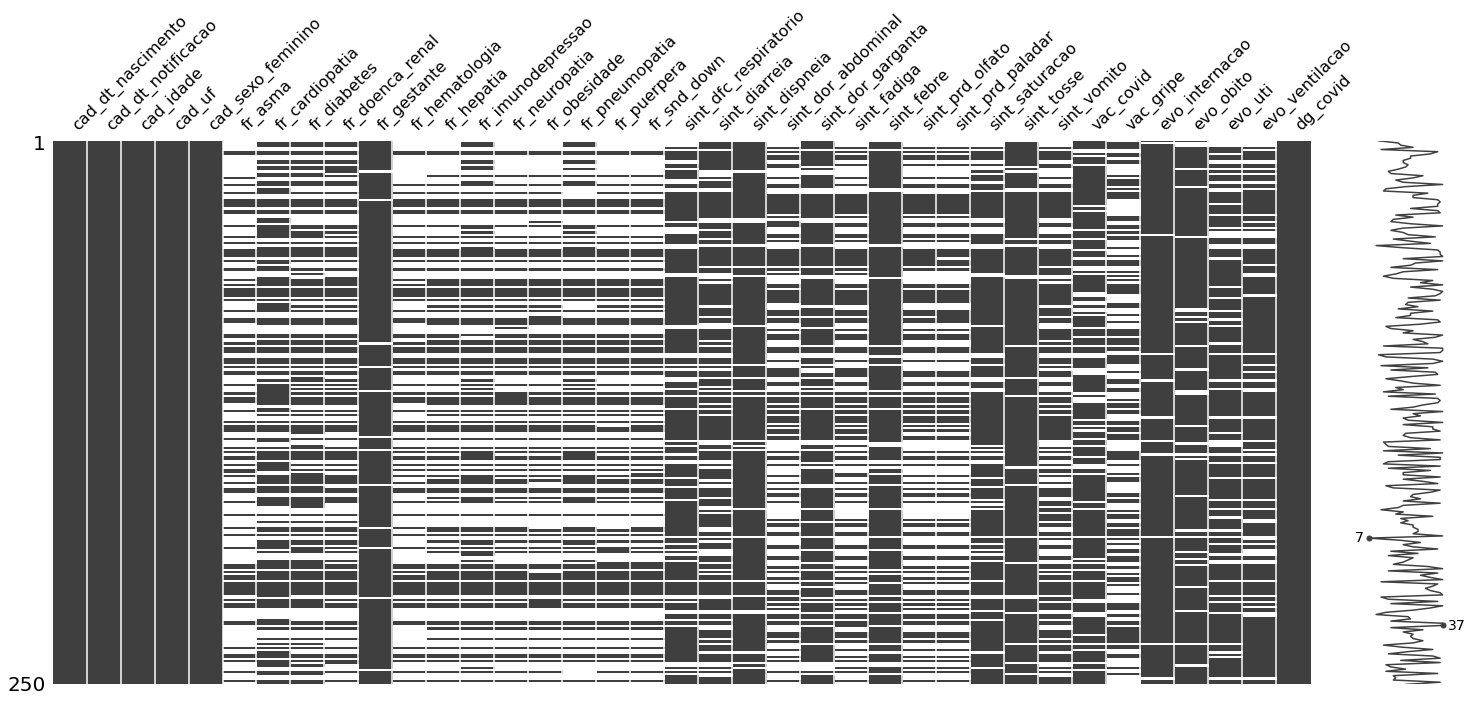

In [3]:
msno.matrix(raw_data.sample(250))

In [4]:
if True:
    percent_missing = raw_data.isnull().sum() * 100 / len(raw_data)
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
    print(missing_value_df)

                       percent_missing
fr_hematologia               69.065383
fr_asma                      68.447357
fr_hepatia                   62.323027
fr_snd_down                  62.223954
fr_puerpera                  62.025949
fr_neuropatia                61.407887
fr_obesidade                 61.003363
sint_dor_abdominal           55.828516
sint_prd_paladar             55.580992
sint_prd_olfato              55.510739
fr_imunodepressao            54.182560
fr_doenca_renal              53.894601
fr_pneumopatia               53.653490
sint_fadiga                  53.365282
vac_gripe                    52.351816
fr_diabetes                  47.956485
fr_cardiopatia               45.100946
sint_vomito                  41.929518
sint_diarreia                33.015984
sint_dor_garganta            25.925712
sint_dfc_respiratorio        24.311961
vac_covid                    23.917519
sint_saturacao               22.878260
evo_ventilacao               21.942600
evo_uti                  

Optamos então por remover algumas colunas. Fizemos isso escolhendo apenas as colunas que o SUS usa desde 2009, exceto evo_ventilacao pois, como provado na entrega anterior, não traria resultados benéficos para as classificações. Além disso, retiramos também as de datas (visto que já há um atributo derivado, idade, que é numérico, portanto mais fácil de usar) e da unidade federativa, pelas excessivas colunas Dummy que ele geraria. De fato, o tempo de execução já tornou-se um grande complicador nessa etapa, e o diminuí-lo aqui (tirando colunas desnecessárias ou pouco itens) é vital. 

In [5]:
PANDEMIC_DAY_ZERO = '2020-02-06'

X_COLUMNS = ['cad_sexo_feminino', 'cad_idade', 'fr_cardiopatia', 'fr_diabetes', 'fr_doenca_renal', 'fr_gestante', 'fr_imunodepressao', 'fr_neuropatia', 'sint_dispneia', 'sint_dor_garganta', 'sint_febre', 'sint_saturacao', 'sint_tosse', 'vac_covid', 'vac_gripe', 'evo_internacao', 'evo_obito', 'evo_uti']

Y_COLUMN = 'dg_covid'

In [6]:
data = raw_data[['cad_sexo_feminino', 'cad_dt_notificacao', 'cad_idade', 'fr_cardiopatia', 'fr_diabetes', 'fr_doenca_renal', 'fr_gestante', 'fr_imunodepressao', 'fr_neuropatia', 'sint_dispneia', 'sint_dor_garganta', 'sint_febre', 'sint_saturacao', 'sint_tosse', 'vac_covid', 'vac_gripe', 'evo_internacao', 'evo_obito', 'evo_uti', 'dg_covid']].dropna()

Além disso, verificamos possibilidade de desbalanceamento nos dados, e não parece ser o caso.

In [9]:
true_covid_cases = data[data.dg_covid == 1]
non_covid_cases = data[(data.cad_dt_notificacao < PANDEMIC_DAY_ZERO)]
unknow_cases = data[(data.dg_covid == 0) & (data.vac_covid == 0) & (data.cad_dt_notificacao >= PANDEMIC_DAY_ZERO)]

print(f'Taxa de casos de covid = {len(true_covid_cases)/(len(non_covid_cases) + len(true_covid_cases))*100:.2f} %')

Taxa de casos de covid = 61.06 %


In [26]:
train = pd.concat([true_covid_cases, non_covid_cases], ignore_index=True)
test = unknow_cases

Toda essa entrega é focada no simples intuito de responder a nossa pergunta inicial: "Houveram subnotificações de SRAG provocada por Covid-19 no Brasil?"  

Assim, optamos por modelos classificativos. Infelizmente, devido ao alto número de linhas e colunas, os classificadores KNN e SVM demoram muito tempo. Assim, não conseguimos executá-los. Optamos entao pelos modelos baseado em árvores de decisão, que lidam muito bem com variáveis discretas, como são quase todas as nossas (exceto Idade). Utilizamos então o modelo de árvore de decisão, de RandomForest, GradientBoosting e AdaBoost.

In [27]:
if True:
    X_TRAIN = train[X_COLUMNS].to_numpy()
    Y_TRAIN = np.ravel(pd.get_dummies(train[Y_COLUMN], drop_first=True).to_numpy())

    X_TEST = test[X_COLUMNS].to_numpy()

    if False:
        CLASSIFIER = KNeighborsClassifier()
        scores = cross_val_score(CLASSIFIER, X_TRAIN, Y_TRAIN, cv=2)
        print('\nKNN')
        print(f'Acurácia: {scores.mean()*100:.2f} +/- {scores.std()*2*100:.2f} %')
        
        CLASSIFIER.fit(X_TRAIN, Y_TRAIN)
        print(f'Taxa de subnotificação prevista: {CLASSIFIER.predict(X_TEST).sum()/len(X_TEST) * 100:.2f} %')

    if False:
        CLASSIFIER = svm.SVC(kernel='linear')
        scores = cross_val_score(CLASSIFIER, X_TRAIN, Y_TRAIN, cv=2)
        print('\nSVM')
        print(f'Acurácia: {scores.mean()*100:.2f} +/- {scores.std()*2*100:.2f} %')

        CLASSIFIER.fit(X_TRAIN, Y_TRAIN)
        print(f'Taxa de subnotificação prevista: {CLASSIFIER.predict(X_TEST).sum()/len(X_TEST) * 100:.2f} %')

    if True:
        CLASSIFIER = DecisionTreeClassifier()
        scores = cross_val_score(CLASSIFIER, X_TRAIN, Y_TRAIN, cv=2)
        print('\nDecision Tree')
        print(f'Acurácia: {scores.mean()*100:.2f} +/- {scores.std()*2*100:.2f} %')

        CLASSIFIER.fit(X_TRAIN, Y_TRAIN)
        print(f'Taxa de subnotificação prevista: {CLASSIFIER.predict(X_TEST).sum()/len(X_TEST) * 100:.2f} %')

    if True:
        CLASSIFIER = RandomForestClassifier()
        scores = cross_val_score(CLASSIFIER, X_TRAIN, Y_TRAIN, cv=2)
        print('\nRandom Forest Classifier')
        print(f'Acurácia: {scores.mean()*100:.2f} +/- {scores.std()*2*100:.2f} %')

        CLASSIFIER.fit(X_TRAIN, Y_TRAIN)
        print(f'Taxa de subnotificação prevista: {CLASSIFIER.predict(X_TEST).sum()/len(X_TEST) * 100:.2f} %')

    if True:
        CLASSIFIER = GradientBoostingClassifier()
        scores = cross_val_score(CLASSIFIER, X_TRAIN, Y_TRAIN, cv=2)
        print('\nGradient Boosting Classifier')
        print(f'Acurácia: {scores.mean()*100:.2f} +/- {scores.std()*2*100:.2f} %')

        CLASSIFIER.fit(X_TRAIN, Y_TRAIN)
        print(f'Taxa de subnotificação prevista: {CLASSIFIER.predict(X_TEST).sum()/len(X_TEST) * 100:.2f} %')

    if True:
        CLASSIFIER = AdaBoostClassifier()
        scores = cross_val_score(CLASSIFIER, X_TRAIN, Y_TRAIN, cv=2)
        print('\nAda Boost Classifier')
        print(f'Acurácia: {scores.mean()*100:.2f} +/- {scores.std()*2*100:.2f} %')

        CLASSIFIER.fit(X_TRAIN, Y_TRAIN)
        print(f'Taxa de subnotificação prevista: {CLASSIFIER.predict(X_TEST).sum()/len(X_TEST) * 100:.2f} %')


Decision Tree
Acurácia: 75.66 +/- 4.36 %
Taxa de subnotificação prevista: 71.13 %

Random Forest Classifier
Acurácia: 78.30 +/- 3.38 %
Taxa de subnotificação prevista: 75.57 %

Gradient Boosting Classifier
Acurácia: 81.50 +/- 1.84 %
Taxa de subnotificação prevista: 81.64 %

Ada Boost Classifier
Acurácia: 80.65 +/- 4.09 %
Taxa de subnotificação prevista: 81.13 %


A conclusão final foi assustadora. Reverificamos o código diversas vezes, e aparentemente o resultado está correto.  
  
Não só é possível verificar que existiram sim subnotificações, como é possível estimar que de aproximadamente 65 a 97% dos casos passíveis de subnotificação foram subnotificados (ou seja, eram casos de Covid que não foram corretamente diagnosticados).

Além disso, é possível perceber que o modelo Gradient Boosting funcionou melhor.

Ademais, note que é bastante necessário revisão do trabalho visto a conclusão de alto valor. Além disso, seria bastante interessante testar outros modelos de predição mais custosos sobre esses dados, mas para isso seriam necessárias implementações mais distribuídas, como as encontradas no Apache Spark.